In [1]:
from scipy.integrate import solve_ivp

In [14]:
%%writefile sim_graph_funs.py
import numpy as np
import matplotlib.pyplot as plt
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from scipy.integrate import solve_ivp
from scipy.optimize import root
from local_stability_funs import *


#colors = ['k','r','b','cyan', 'magenta','orange',
#         'gray', 'green']
colors = ['r', 'orange', 'magenta', 'purple', 'blue', 
          'cornflowerblue', 'turquoise','k', 'gray']
markers = ["o","","v", ""]
Plab = r'$P$, Scaled Pred. Pop Size'
N1lab = r'$N_1$, Scaled Big Prey'+ '\nDensity'
N2lab = r'$N_2$, Scaled Small Prey' + '\nDensity'
Tlab = r'$T$, Scaled time'
mean_x_lab = "Mean Group Size\n Membership"
freq_x_lab = r'Freq$(x)$'
β1lab = r'$\beta_1$'
Fxlab = r'F$(x)$'
figure_ops = dict(bbox_inches = 'tight', dpi = 600)

def format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = False,
             ncol_legend = 1):
    ax.set_xlabel(xlab, fontsize = fs_labs)
    ax.set_ylabel(ylab, fontsize = fs_labs)
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    if if_legend:
        ax.legend(fontsize = fs_legend, ncol = ncol_legend)
        
def get_results(out2,x_max):
    '''
    gets results from output of simulation
    out: dictionary that's output of solve_ivp
    x_max: max group size

    @returns:
    T, N1, N2, P, mean_x
    '''
    P, N1, N2 = out2.y[0:3]
    F_of_x_vec = out2.y[3:]
    mean_x = mean_group_size_membership(F_of_x_vec.T, x_max, P)
    T = out2.t
    return T, N1, N2, P, F_of_x_vec, mean_x
def add_arrow(line, start_ind = None,  direction='right', size=15, color=None):
    """
    add an arrow to a line.
    Edited from https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot

    line:       Line2D object
    start_ind:   index of start of the arrow
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    #position=None,
    
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    #if position is None:
    #    position = xdata.mean()
    # find closest index
    if start_ind == None:
        position = xdata.mean()
        start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )
    


def plot_all(T,N1,N2,P,mean_x, xlim = [-10, 600]):
    fig, ax = plt.subplots(1,1)
    ax.plot(T,N2,'k', label = r'$N_2$')
    ax.plot(T,N1,'r', label = r'$N_1$')
    ax.plot(T,P,'b', label = r'$P$')
    if isinstance(mean_x, np.ndarray):
        ax.plot(T, mean_x, 'magenta', label = r'$\bar{x}$')
    format_ax(ax, xlab = Tlab,ylab = '',if_legend = True,
         xlim = xlim,fs_labs = 18)
    return fig, ax
def plot_x_vs_y(x,y,xlab,ylab,arrow_inds):
    fig, ax = plt.subplots(1,1)
    l = ax.plot(x,y,'k')
    for ind in arrow_inds:
        add_arrow(l[0], start_ind = ind)
        format_ax(ax, xlab = xlab, ylab = ylab, fs_labs = 18)
    return fig, ax
    
def plot_portion_x(fig, ax, out, x_max, xlim = [-1,500]):
    '''
    plots time vs x*F(x)
    out is output from solve_ivp
    @inputs
    ax is the axis that is already made
    out is the output of solve_ivp

    @ returns: fig, ax
    '''
    T = out.t
    print(T[-1])
    F_of_x_vec = out.y[3:]
    P = out.y[0]
    # find F_of_x that are big enough
    xvec = np.arange(1,x_max+1,1)
    xF = xvec*F_of_x_vec.T
    portion_x = (xF.T/P).T
    xlist = []
    xflist = []
    for x in range(1,x_max+1):
        portion_x_curr = portion_x[:,x-1]
        if max(portion_x_curr)>.1:
            xlist.append(x)
            xflist.append(portion_x_curr)
            
    labels = [f'x={x}' for x in xlist]
    for i, portion_x_curr in enumerate(xflist):
        ax.plot(T, portion_x_curr, label = labels[i], c = colors[i])
        
    format_ax(ax,Tlab,r'$xF(x)/P$', xlim = xlim, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = True)
    return fig, ax

def print_param_caption(ξ, Tx, η1, η2, A1, β1, β2, H1, H2, α1_of_1, α2_of_1, 
                        s1, s2, α2_fun_type,**params):
    caption = 'The parameters are '
    caption += f'$\\xi = {ξ}, \\eta_1 = {η1}, \\eta_2 = {η2}, '
    caption += f'A_1 = {A1}, \\beta_1 = {β1}, \\beta_2 = {β2}, '
    caption += f'H_1 = {H1}, H_2 = {H2}, T_x = {Tx}, ' 
    if α2_fun_type == 'constant':
        caption += f'\\alpha_1(1) = {α1_of_1}, s_1 ={s1}$, '
        caption += f'and $\\alpha_2(x) = {α2_of_1}$ is constant.'
    else:
        caption += f'\\alpha_1(1) = {α1_of_1}, \\alpha_2(1) = {α2_of_1}, '
        caption += f's_1 = {s1}$, and $s_2 = {s2}$' 
    
    print(caption)




def plot_F_equilibrium(paramvec, Fxvecs, xvec, xlab, ylab, 
                       ncol_legend = 1, xlim = None, ylim = None,
                       fig = None, ax = None):
    '''
    Plots distribution F(x)
    can take for Fxvecs either F(x) or \bar{F}(x), the frequency of predators in groups of size x
    '''
    if ax == None:
        fig, ax = plt.subplots(1,1)
        
    
    
    colors_x = ['r', 'orange', 'magenta', 'purple', 'blue', 'cornflowerblue', 'k']

    xmax = len(xvec)
    if Fxvecs.shape[1] == xmax:
        Fxvecs = Fxvecs.T
        
    for x in xvec:
        if np.any(Fxvecs[x-1]>1e-2):
            ax.plot(paramvec, Fxvecs[x-1], colors_x[x-1], label = r'$x=$%d'%x)
    format_ax(ax,xlab,ylab, fs_labs = 18, fs_legend = 16, if_legend = True,
             ncol_legend = ncol_legend)
    return fig, ax
def initiate_f_first_x(P0, x_f, x_max):
    xvec = np.arange(1,x_max+1,1)
    F0 = np.zeros(x_max)
    F0[0:x_f] = (P0/x_f)
    F0 = F0/xvec
    return F0
    
def get_equilibrium(params, N1_0 = 0.5, N2_0 = 0.4, P_0 = 3, F_of_x_vec = None):
    '''
    finds the equilibrium using Fsolve for the population dynamics and group dynamics system
    if not given F_of_x_vec, then just has everyone initially solitary
    
    @returns:
    N1_eq, N2_eq, F_eq, P_eq, mean_x_eq
    '''
    x_max = params['x_max']
    xvec = np.arange(1,x_max+1,1)
    if ~isinstance(F_of_x_vec, np.ndarray):
        x_f = 2 if x_max > 2 else x_max
        F0 = initiate_f_first_x(P_0, x_f, x_max)
        
    x0 = [N1_0, N2_0, *F0]
    out = root(fun = nullclines_no_P, x0 = x0, 
                                  args = (params))
    return out

def iterate_and_solve_equilibrium(params, t_f = 1000, tol = 1e-8):
    '''
    iterates from p = 3, N1 = 0.8, N2 = 0.7, 
    predators split evenly between groups of 1, 2, or 3
    then uses root to find equilibrium

    @returns
    P,N1,N2,F,mean_x at equilibrium, 
    and success (Boolean; true if the equilibria values are all nonnegative)
    '''
    x_max = params['x_max']
    x0 = [3, 0.8, 0.7, *initiate_f_first_x(3, 2, x_max)]
    out2 = solve_ivp(full_model, [0, t_f], x0, method="LSODA",
                args=(True,params))
    T, N1, N2, P, F_of_x_vec, mean_x = get_results(out2, x_max)

    out = get_equilibrium(params, N1_0 = N1[-1], N2_0 = N2[-1], 
                          F_of_x_vec = F_of_x_vec[:,-1])
    P_eq, N1_eq, N2_eq, F_eq, mean_x_eq, success =get_results_eq(out,x_max)

    # to be successful, sum x*F = P
    sum_x_F = np.sum(np.arange(1,x_max+1,1)*F_eq)
    success = success and (np.abs(sum_x_F - P_eq )< tol)
    
    return P_eq, N1_eq, N2_eq, F_eq, mean_x_eq, success

def get_results_eq(out, x_max):
    xvec = np.arange(1,x_max+1,1)
    F_eq = out.x[2:]
    P_eq = np.sum(xvec*F_eq); 
    N1_eq = out.x[0]
    N2_eq = out.x[1]
    mean_x_eq = mean_group_size_membership(F_eq,x_max,P_eq)

    if np.any(np.array([P_eq, N1_eq, N2_eq, *F_eq, mean_x_eq])<0) or out.success == False:
        success = False
        return np.nan, np.nan, np.nan, np.nan, np.nan, success
    success = True
    return P_eq, N1_eq, N2_eq, F_eq, mean_x_eq, success

def generate_params_using_weitz(A1, β2, H2, η2, weight_fraction_prey, 
                                α1_of_1 = 0.05, α2_of_1 = 0.95, s1 = 2, 
                                s2 = 2, α2_fun_type = 'sigmoid', x_max = 10, ξ = 2,
                                d = 10, Tx = .01):
    attack_fraction = 1/(1/A1 - 1)
    β1 = β2 * attack_fraction * weight_fraction_prey**(0.25)
    H1 = H2 * attack_fraction * weight_fraction_prey**(0.25)
    η1 = η2 * weight_fraction_prey**(-0.25)
    params = dict(η1 = η1, η2 = η2, A1 = A1, β1 = β1, β2 = β2, 
                   H1=H1, H2=H2, 
                  α1_of_1=α1_of_1, α2_of_1=α2_of_1, 
                  s1=s1, s2=s2, α2_fun_type = α2_fun_type,
                  x_max = x_max, ξ = ξ, d = d,
                 Tx = Tx, r = 0, γ = 0, pop_process = True)
    return params
    
def plot_freq_x_eq(paramvec, Fxvecs, xvec, Pvec, xlab, ylab = r'Freq$(x)$', 
                       ncol_legend = 1, xlim = None, ylim = None,
                       fig = None, ax = None):
    prob_x = (xvec*Fxvecs).T/Pvec
    fig, ax = plot_F_equilibrium(paramvec, prob_x, xvec, xlab, ylab, 
                       ncol_legend = ncol_legend, xlim = None, ylim = None,
                       fig = None, ax = None)
    return fig, ax

def abs_nullclines_no_P(initialstate, params):
    return np.sum(np.abs(nullclines_no_P(initialstate, params)))

def plot_W_mode_comparison(xvec,N1vec,N2vec,Fxvecs, params, fig = None, ax = None):
    '''
    Plots W(x) for the mode of x, and for x=1, and the mode of x + 1
    '''
    if fig == None:
        fig,ax = plt.subplots(1,1)
    x_mode = np.argmax(xvec*Fxvecs,1)+1
    W_of_mode_x_plus_1 = per_capita_fitness_from_prey_non_dim(x_mode + 1, N1vec, N2vec, **params)
    W_of_mode_x = per_capita_fitness_from_prey_non_dim(x_mode, N1vec, N2vec, **params)
    W_of_1 = per_capita_fitness_from_prey_non_dim(1, N1vec, N2vec, **params)
    ax.plot(β1vec, W_of_1, 'crimson', label = r'solitary')
    ax.plot(β1vec, W_of_mode_x, 'magenta', label = r'mode$(x)$')
    ax.plot(β1vec, W_of_mode_x_plus_1 - W_of_1, 'purple', label = r'mode$(x+1)$')

    format_ax(ax, β1lab, 'Per Capita Fitness', if_legend = True)
    return fig, ax

def iterate_to_eq(initialstate, t_f,params):
    '''
    try to iterate to eq in t_f time steps
    '''
    out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))

    # extract results
    T,N1,N2,P,Fxvec, mean_x = get_results(out2, params['x_max'])
    N1,N2,P,mean_x = [ item[-1] for item in [N1,N2,P,mean_x]]
    F = Fxvec[:,-1]
    timederivatives = full_model(T[-1], [P,N1,N2,*F],True,params)
    success = np.all(np.abs(np.array(timederivatives)) < 1e-9)
    
    
    return np.array([P, N1, N2, *F]), success, mean_x, full_trajectory
    
def get_equilibria_vary_param(paramvec, paramkey, **params):
    '''
    Get a list of equilibrium values corresponding to the parameters
    '''

    



    x_max = params['x_max']
    xvec = np.arange(1,x_max+1,1)
    Pvec = np.zeros(len(paramvec))
    meanxvec = np.zeros(len(paramvec))
    Fxvecs  = np.zeros((len(paramvec), x_max))
    N1vec = Pvec.copy()
    N2vec = Pvec.copy()
    success_vec = Pvec.copy()
    stability_vec = Pvec.copy()
    
    for i, param in enumerate(paramvec):
        params = params.copy()
        params[paramkey] = param

        # try to use root #
        
        out_eq = iterate_and_solve_equilibrium(params, t_f = 5)
        P, N1, N2, F, mean_x, success = out_eq
        
        if success==False:
            # try to get to equilibrium in just 200 steps #
            
            t_f = 500
            initialstate = [3,0.5,0.4, 1, *np.zeros(x_max-1)]
            finalpoint, success, mean_x, full_trajectory = iterate_to_eq(initialstate, t_f,
                                                                         params)

            # if that doesn't work, now do another 2000 steps
            if success == False:
                out = iterate_to_eq(finalpoint, 2000,params)   
                finalpoint, success, mean_x, full_trajectory = out

            P,N1,N2 = finalpoint[0:3]
            F = finalpoint[3:]
        success_vec[i] = success
        
        Fxvecs[i,:] = F
        Pvec[i] = P
        N1vec[i] = N1
        N2vec[i] = N2
        meanxvec[i] = mean_x


        # check stability
        try:
            if np.any(np.isnan(np.array([P,N1,N2,*F]))):
                stability_vec[i] = np.nan
        except TypeError:
            stability_vec[i] = np.nan
        else:
            J = fun_Jac(N1,N2,np.array(F),**params)
            stability = classify_stability(J)
            if stability == "Stable (attractive)":
                stability_vec[i] = 1
            elif stability == "Unstable":
                stability_vec[i] = -1
            else:
                stability_vec[i] = 0
        
    return Pvec, N1vec, N2vec, Fxvecs,meanxvec,success_vec, stability_vec

Overwriting sim_graph_funs.py


In [226]:
get_equilibrium?

Signature: get_equilibrium(params, N1_0=0.5, N2_0=0.4, P_0=3, F_of_x_vec=None)
Docstring:
finds the equilibrium using Fsolve
if not given F_of_x_vec, then just has everyone initially solitary

@returns:
N1_eq, N2_eq, F_eq, P_eq, mean_x_eq
File:      /var/folders/qd/9pxy4gkx37575w3vclv1xfk40000gp/T/ipykernel_54882/2285120337.py
Type:      function

In [ ]:
def get_equilibria_vary_param(paramkey, paramvec, params):
    P_vec = paramvec.copy()
    for i, param in enumerate(paramvec):
        params = 

In [249]:



weight_fraction_prey = np.arange(1,10,0.5)
P_vec = weight_fraction_prey.copy()
x_max = 10
for i, wf in enumerate(weight_fraction_prey):
    params = generate_params_using_weitz(A1=0.5, β2 = 1, H2 = 0, η2 = 0.5,
                                         weight_fraction_prey = wf)
    out = get_equilibrium(params)
    P_eq, N1_eq, N2_eq, F_eq, mean_x_eq, success = iterate_and_solve_equilibrium(params, t_f = 2)
    P_vec[i] = P_eq
    if success == False:
        P_eq, N1_eq, N2_eq, F_eq, mean_x_eq, success = iterate_and_solve_equilibrium(params)
        P_vec[i] = P_eq
        

In [250]:
P_vec

array([       nan, 3.32641007, 2.92051563, 2.66748822, 2.49296585,
       2.36433991, 2.26499231, 2.18553564, 2.12025197, 2.06545154,
       2.01864211, 1.97807664, 1.94249223, 1.91095201, 1.8827454 ,
       1.85732308, 1.83425319, 1.81319125])

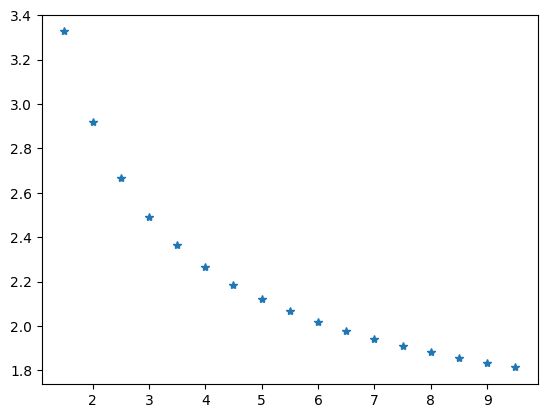

In [251]:
plt.plot(weight_fraction_prey, P_vec, '*')

In [252]:
params = generate_params_using_weitz(A1=0.5, β2 = 1, H2 = 2, η2 = 0.5,weight_fraction_prey = 10)

In [176]:
get_equilibrium(params)

 message: The solution converged.
 success: True
  status: 1
     fun: [ 1.568e-13  1.653e-12 -4.377e-09  2.225e-09 -2.383e-11
            1.032e-13 -2.649e-16 -4.964e-18  1.614e-20  3.637e-22
            1.854e-24  5.175e-27]
       x: [ 9.182e-01  3.450e-01  1.231e+00  7.152e-02  5.206e-04
            1.105e-06  1.706e-09  2.172e-12  2.366e-15  2.255e-18
            1.910e-21  1.456e-24]
  method: hybr
    nfev: 25
    fjac: [[-1.098e-02  5.118e-03 ...  2.211e-19  4.486e-22]
           [ 7.341e-01 -2.566e-01 ... -5.754e-18 -9.988e-21]
           ...
           [ 1.416e-15  1.740e-16 ... -1.000e+00  7.081e-04]
           [ 3.262e-18  3.983e-19 ... -7.081e-04 -1.000e+00]]
       r: [ 1.965e+01 -3.841e+01 ... -5.025e+02  5.018e+02]
     qtf: [ 9.135e-08  3.613e-09 -2.419e-09 -4.160e-09  5.852e-12
           -1.757e-12  7.153e-15  6.084e-17 -7.190e-19 -7.019e-21
           -2.626e-23 -6.028e-26]

# Weitz Scaling parameters

In [20]:
#H=1
A1 = 0.5
attack_fraction = 1/(1/A1 - 1)
weight_fraction_prey = 10 # m1/m2

β2 = 1; H2 = 2; η2 = 0.5
β1 = β2 * attack_fraction * weight_fraction_prey**(0.25)
H1 = H2 * attack_fraction * weight_fraction_prey**(0.25)
η1 = η2 * weight_fraction_prey**(-0.25)



x_max = 10
params_base = dict(η1 = η1, η2 = η2, A1 = A1, β1 = β1, β2 = β2, 
                   H1=H1, H2=H2, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'sigmoid',
                  x_max = x_max, ξ = 2, d = 10,
                 Tx = .01, r = 0, γ = 0, pop_process = True)


In [21]:
params = params_base.copy()

In [22]:
x_max = params['x_max']
x_f = 4 if x_max > 4 else x_max
F0 = np.zeros(x_max)
F0[0:x_f]

array([0., 0., 0., 0.])

In [28]:
iterate_and_solve_equilibrium?

Signature: iterate_and_solve_equilibrium(params, t_f=1000)
Docstring:
iterates from p = 3, N1 = 0.8, N2 = 0.7, 
predators split evenly between groups of 1, 2, or 3
then uses root to find equilibrium

@returns
P,N1,N2,F,mean_x at equilibrium, 
and success (Boolean; true if the equilibria values are all nonnegative)
File:      /var/folders/_4/t51wvvv53c35d1q0pv8mywxr0000gq/T/ipykernel_86949/1254172374.py
Type:      function

In [35]:
P,N1,N2,F,mean_x,success = iterate_and_solve_equilibrium(params.copy(), t_f = 2)
print(F)

[1.24675552e+00 4.32098312e-02 1.75351442e-04 1.90101797e-07
 1.47655237e-10 9.44009770e-14 5.16321243e-17 2.47002668e-20
 1.05024029e-23 4.01888891e-27]


In [143]:
P0 = 3
xvec = np.arange(1,11,1)
F0 = np.zeros(x_max) 
F0[0:2] = P0/2
F0 = F0/xvec
x0 = [0.8, 0.7, *F0]
params = params_base.copy()

out = root(fun = nullclines_no_P, x0 = x0, args = (params))

In [146]:
out.success

True

In [145]:
out.x

array([9.18249546e-01, 3.44957930e-01, 1.23103242e+00, 7.15181976e-02,
       5.20552700e-04, 1.10501744e-06, 1.70616996e-09, 2.17213180e-12,
       2.36635778e-15, 2.25494432e-18, 1.90986340e-21, 1.45579673e-24])

In [137]:
f_all_solitary = np.zeros(10); f_all_solitary[0] = P0
params = params_base.copy()
out2 = solve_ivp(full_model, [0, 2000], [P0,0.5, 0.4, *f_all_solitary], method="LSODA",
                args=(True,params))

In [138]:
T,N1,N2,P,Fxvec, mean_x = get_results(out2, 10)


In [139]:
out_end = np.round([N1[-1], N2[-1], *Fxvec[:,-1]],5)
out = root(fun = nullclines_no_P, x0 = out_end, args = (params))

In [140]:
out.x

array([9.18249546e-01, 3.44957930e-01, 1.23103242e+00, 7.15181976e-02,
       5.20552700e-04, 1.10501744e-06, 1.70616996e-09, 2.17213180e-12,
       2.36635778e-15, 2.25494432e-18, 1.90986340e-21, 1.45579673e-24])

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$N_1$, Scaled Big Prey\nPop Size', ylabel='$P$, Scaled Pred. Pop Size'>)

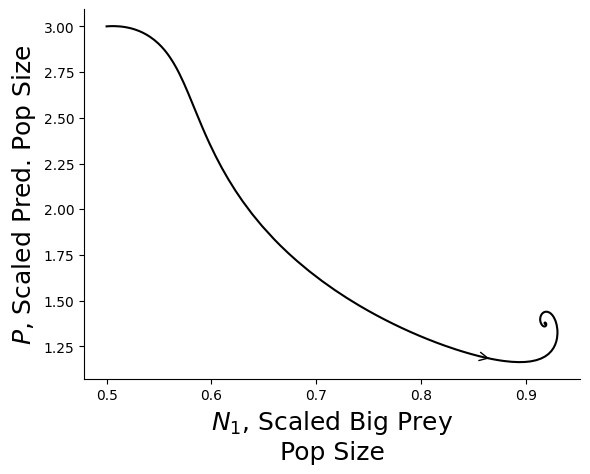

In [106]:
plot_x_vs_y(N1,P,N1lab,Plab,[100])

In [153]:
F_of_x_vec

array([0.3       , 0.15      , 0.1       , 0.075     , 0.06      ,
       0.05      , 0.04285714, 0.0375    , 0.03333333, 0.03      ])

In [144]:
out = get_equilibrium(params_base.copy())

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 4.129e-03  2.313e-03  5.658e-03 -7.858e-03 -6.351e-03
            4.506e-03 -1.249e-02  1.713e-03 -1.457e-02  4.653e-03
            1.407e-02 -1.331e-02]
       x: [-3.092e-01  1.263e-01  5.993e-02  3.248e-01 -9.217e-02
            2.821e-01 -2.059e-01  3.011e-01 -1.676e-01  1.936e-01
           -6.279e-02  9.788e-02]
  method: hybr
    nfev: 102
    fjac: [[ 7.026e-04 -4.825e-12 ...  2.195e-01 -1.368e-01]
           [-5.342e-02 -1.390e-02 ...  9.005e-02 -5.816e-02]
           ...
           [ 3.748e-02 -2.489e-03 ... -1.494e-01  8.294e-01]
           [ 4.389e-01 -1.761e-03 ... -4.099e-01 -4.433e-01]]
       r: [-2.847e+02  2.187e+03 ... -2.085e+00 -1.059e+00]
     qtf: [-5.391e-03 -1.143e-02  1.325e-03  1.227e-03  7.104e-03
           -4.459e-03  5.270e-03 -1.073e-02  1.669e-02  1.236e-02
           -8.609e-03  7.937e-03

In [84]:
initialstate = np.array([3,0.4, 0.5, 3, *np.zeros(9)])
t_f = 1000
params = params_base.copy()
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
T,N1,N2,P,Fxvec, mean_x = get_results(out2, 10)

In [33]:
bounds = [(0,1),(0,1)]
for x in range(1, params['x_max']+1):
    bounds.append((0,None))
    
initialstate = initialstate + 0.01
def abs_nullclines_no_P(initialstate, params):
    return np.sum(np.abs(nullclines_no_P(initialstate, params)))
    
x_max = params['x_max']
#N1, N2 = initialstate[0:2]
#F_of_x_vec = initialstate[2:]

out = minimize(fun = abs_nullclines_no_P, x0 = initialstate[1:], args = (params), 
               bounds = bounds)

In [34]:
out

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.1999999999999996
        x: [ 2.058e-15  1.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00]
      nit: 13
      jac: [-2.000e-01 -4.000e-01  2.750e+00  3.037e+02  4.543e+02
             6.051e+02  7.559e+02  9.067e+02  1.057e+03  1.208e+03
             1.359e+03  1.510e+03]
     nfev: 1183
     njev: 91
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>

In [ ]:
x_max = params['x_max']
if ~isinstance(F_of_x_vec, np.ndarray):
    F_of_x_vec = np.zeros(x_max)
    F_of_x_vec[0] = P_0
x0 = [N1_0, N2_0, *F_of_x_vec]
out, infodict, ier, mesg = fsolve(func = nullclines_no_P, x0 = x0, 
                              args = (params), full_output = 1)
F_eq = out[2:]
P_eq = np.sum(np.arange(1,x_max+1,1)*F_eq); 
N1_eq = out[0]
N2_eq = out[1]
mean_x_eq = mean_group_size_membership(F_eq,x_max,P_eq)

if np.any( np.round(np.array([N1_eq, N2_eq, *F_eq, P_eq, mean_x_eq]),8) <0):
    return np.nan, np.nan, np.nan, np.nan, np.nan
else:
    return N1_eq, N2_eq, F_eq, P_eq, mean_x_eq

In [85]:
xvec = np.arange(1,x_max+1,1)
β1vec = np.arange(1,10,0.2)
Pvec = np.zeros(len(β1vec))
meanxvec = np.zeros(len(β1vec))
Fxvecs  = np.zeros((len(β1vec), x_max))
N1vec = Pvec.copy()
N2vec = Pvec.copy()

for i, β1 in enumerate(β1vec):
    params = params_base.copy()
    params['β1'] = β1
    initialstate = np.array([3, 0.5, 0.5, 3, *np.zeros(9)])
    t_f = 2000
    out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
    T,N1,N2,P,Fxvec, mean_x = get_results(out2, 10)
    #N1_eq, N2_eq, F_eq, P_eq, mean_x_eq = get_equilibrium(params)
    Fxvecs[i,:] = Fxvec[:,-1]
    Pvec[i] = P[-1]
    N1vec[i] = N1[-1]
    N2vec[i] = N2[-1]
    meanxvec[i] = mean_x[-1]
    

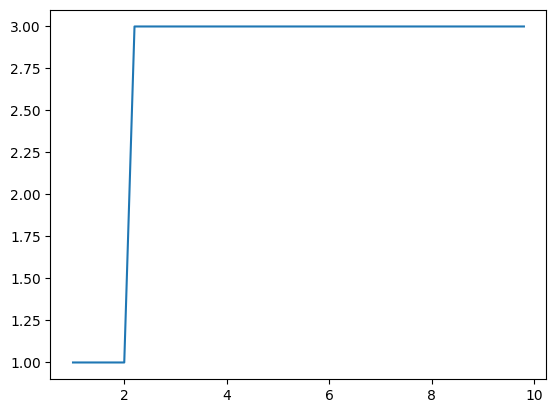

In [103]:
plt.plot(β1vec, x_mode)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\beta_1$', ylabel='Per Capita Fitness'>)

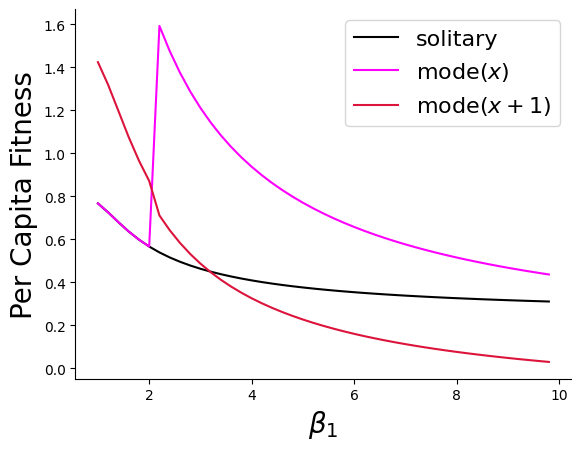

In [132]:
plot_W_mode_comparison(xvec,Fxvecs)

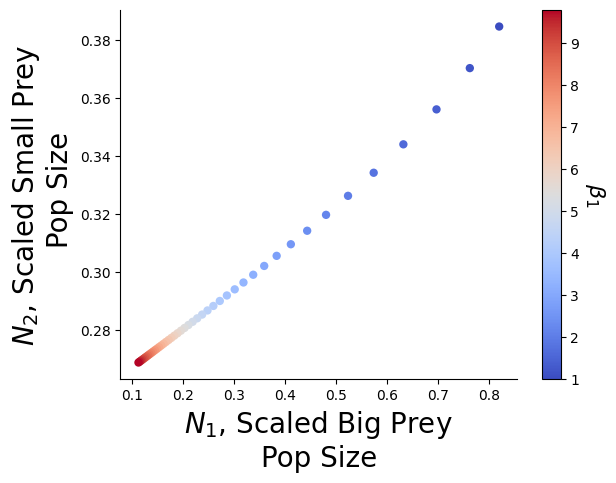

In [79]:
from matplotlib import cm

fig, ax = plt.subplots(1,1)
p = plt.scatter(N1vec,N2vec, c = β1vec, cmap = 'coolwarm', edgecolor='none')
cb = plt.colorbar(p, label = β1lab)
cb.set_label(label=β1lab, rotation = 270, fontsize = 16, labelpad = 20)
#plt.plot(N1vec,N2vec, 'k')
format_ax(ax,N1lab,N2lab)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\beta_1$', ylabel='Freq$(x)$'>)

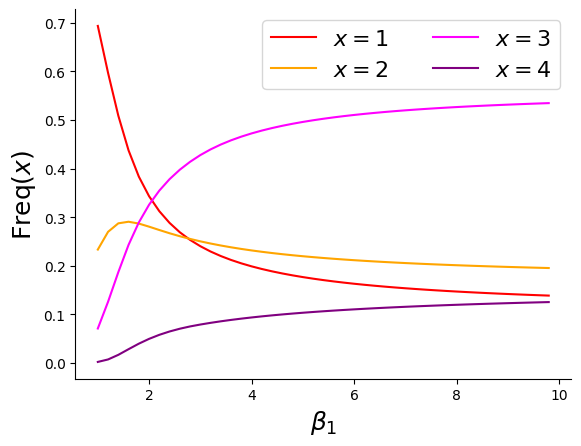

In [49]:
freq_x_lab = r'Freq$(x)$'
plot_freq_x_eq(β1vec, Fxvecs, xvec, P, β1lab, 
                       ncol_legend = 2,
                       )

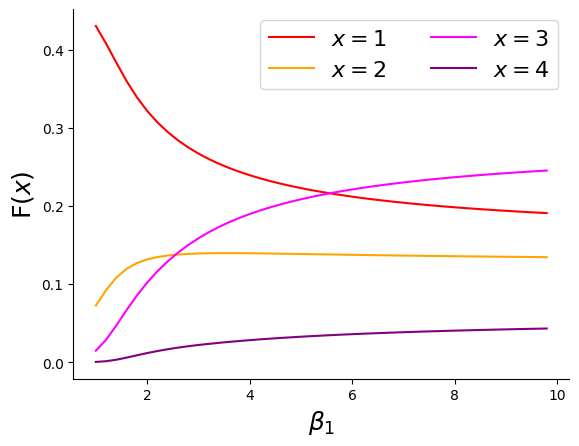

In [50]:
fig,ax = plot_F_equilibrium(β1vec, Fxvecs, xvec, β1lab, Fxlab, ncol_legend=2)

10

In [83]:
Fxvecs.shape[1]

10

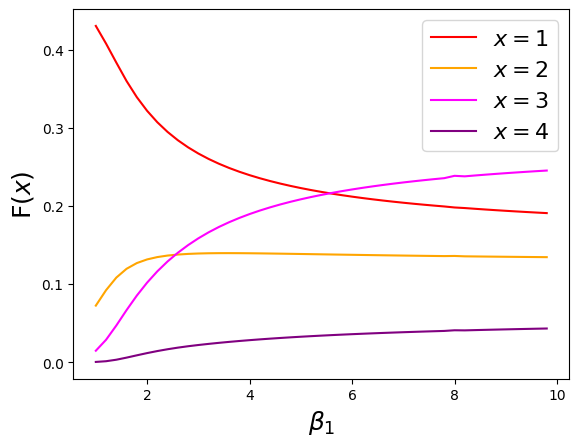

In [80]:

colors_x = ['r', 'orange', 'magenta', 'purple', 'blue', 'cornflowerblue', 'k']
for x in xvec:
    if np.any(prob_x[x-1]>1e-2):
        plt.plot(β1vec, (Fxvecs.T)[x-1], colors_x[x-1], label = r'$x=$%d'%x)
    




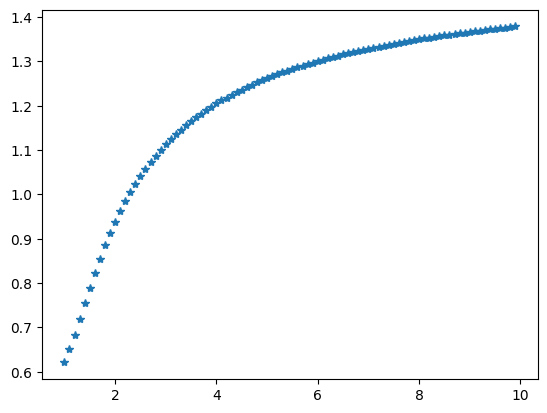

In [14]:
plt.plot(β1vec, Pvec, '*')

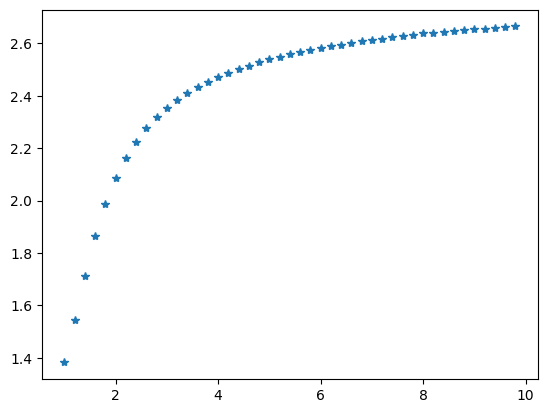

In [16]:
plt.plot(β1vec, meanxvec, '*')

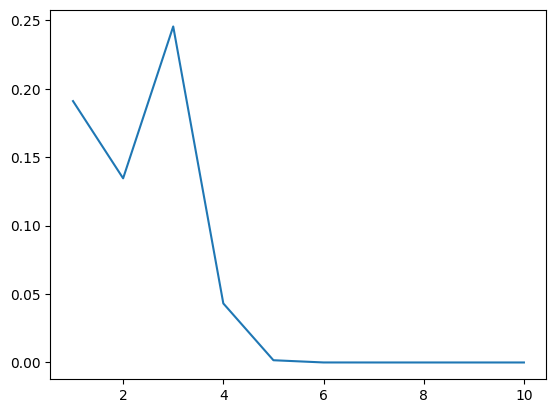

In [26]:
xvec = np.arange(1,11,1)
plt.plot(xvec,Fxvec[:,-1])